# Pedro de Figueiredo Abissamra

## Rede CNN Proposta

In [1]:
#Bibliotecas de processamento d sinal
import scipy.io as io
from scipy import signal
import numpy as np
import h5py
import math
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

#Biblioteca de aprendizado de máquina
import tensorflow as tf
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.utils import Sequence
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

2024-12-11 11:58:11.405280: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 11:58:11.701380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 11:58:12.399542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Verifica se existe GPU disponível
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Verifica detalhes da GPU, se disponível
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("Using GPU:", tf.config.experimental.list_physical_devices('GPU')[0])
else:
    print("No GPU detected, using CPU")


Num GPUs Available:  1
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-12-11 11:58:14.248813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-11 11:58:14.416368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-11 11:58:14.416730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Limita o crescimento da memória da GPU
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
# Caminho do dataset
dataset_path = "/home/pedro/Downloads/INPE/archive/"

In [5]:
# Impotação dos dados de entrada
with h5py.File(dataset_path +'X_train.mat', 'r') as f:
    X_train = np.array(f['X_train'], dtype='float32').T
with h5py.File(dataset_path +'X_val.mat', 'r') as f:
   X_val = np.array(f['X_val'], dtype='float32').T
with h5py.File(dataset_path +'X_test.mat', 'r') as f:
    X_test = np.array(f['X_test'], dtype='float32').T

In [6]:
# Importação dos dados de saída e labels
Y_train = io.loadmat(dataset_path + 'Y_train.mat')['Y_train']
Y_val = io.loadmat(dataset_path + 'Y_val.mat')['Y_val']
Y_test = io.loadmat(dataset_path + 'Y_test.mat')['Y_test']
lbl_train = io.loadmat(dataset_path + 'lbl_train.mat')['lbl_train']
lbl_val = io.loadmat(dataset_path + 'lbl_val.mat')['lbl_val']
lbl_test = io.loadmat(dataset_path + 'lbl_test.mat')['lbl_test']

In [7]:
# Verificação do formato dos dados de entrada
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# Verificação do formato dos dados de saída
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

# Verificação do formato das labels
print(lbl_train.shape)
print(lbl_test.shape)
print(lbl_val.shape)

(469200, 1024, 2)
(156400, 1024, 2)
(156400, 1024, 2)
(469200, 23)
(156400, 23)
(156400, 23)
(469200, 6)
(156400, 6)
(156400, 6)


In [8]:
# Contagem da quantidade de amostras para cada um dos tipos de modulação para o dataset completo
count = np.zeros(24)
for i in range (len(Y_train)-1):
    count[int(lbl_train[i,0])] += 1
print(count)

count = np.zeros(24)
for i in range (len(Y_test)-1):
    count[int(lbl_test[i,0])] += 1
print(count)

count = np.zeros(24)
for i in range (len(Y_val)-1):
    count[int(lbl_val[i,0])] += 1
print(count)

[    0. 20400. 20400. 20400. 20400. 20400. 20400. 20400. 20400. 20400.
 20400. 20400. 20400. 20400. 20400. 20400. 20400. 20400. 20400. 20400.
 20400. 20400. 20400. 20399.]
[   0. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800.
 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6799.]
[   0. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800.
 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6800. 6799.]


In [9]:
# Seleção das modulações desejadas do dataset
desired_vals = [0, 4, 5, 8, 10, 11, 12, 13, 14, 21, 22]

# Vetores para particionamento das amostras de treino
slices_X_train = []
slices_Y_train = []
slices_lbl_train = []

# Criação dos novos dados de treinamento
for i in range(len(desired_vals)):
    slice_start = desired_vals[i] * 20400
    slice_end = (desired_vals[i] * 20400)+20400
    slices_X_train.append(X_train[slice_start:slice_end])
    slices_Y_train.append(Y_train[slice_start:slice_end])
    slices_lbl_train.append(lbl_train[slice_start:slice_end])

new_X_train = np.concatenate(slices_X_train, axis=0)
new_Y_train = np.concatenate(slices_Y_train, axis=0)
new_Y_train = new_Y_train[:, desired_vals]
new_lbl_train = np.concatenate(slices_lbl_train, axis=0)

# Verificação do formato dos novos dados de treinamento
print("New X_train shape:", new_X_train.shape)
print("New Y_train shape:", new_Y_train.shape)
print("New lbl_train shape:", new_lbl_train.shape)

# Vetores para particionamento das amostras de teste
slices_X_test = []
slices_Y_test = []
slices_lbl_test = []

# Criação dos novos dados de teste
for i in range(len(desired_vals)):
    slice_start = desired_vals[i] * 6800
    slice_end = (desired_vals[i] * 6800)+6800
    slices_X_test.append(X_test[slice_start:slice_end])
    slices_Y_test.append(Y_test[slice_start:slice_end])
    slices_lbl_test.append(lbl_test[slice_start:slice_end])

new_X_test = np.concatenate(slices_X_test, axis=0)
new_Y_test = np.concatenate(slices_Y_test, axis=0)
new_Y_test = new_Y_test[:, desired_vals]
new_lbl_test = np.concatenate(slices_lbl_test, axis=0)

# Verificação do formato dos novos dados de teste
print("New X_test shape:", new_X_test.shape)
print("New Y_test shape:", new_Y_test.shape)
print("New lbl_test shape:", new_lbl_test.shape)

# Vetores para particionamento das amostras de validação
slices_X_val = []
slices_Y_val = []
slices_lbl_val = []

# Criação dos novos dados de validação
for i in range(len(desired_vals)):
    slice_start = desired_vals[i] * 6800
    slice_end = (desired_vals[i] * 6800)+6800
    slices_X_val.append(X_val[slice_start:slice_end])
    slices_Y_val.append(Y_val[slice_start:slice_end])
    slices_lbl_val.append(lbl_val[slice_start:slice_end])

new_X_val = np.concatenate(slices_X_val, axis=0)
new_Y_val = np.concatenate(slices_Y_val, axis=0)
new_Y_val = new_Y_val[:, desired_vals]
new_lbl_val = np.concatenate(slices_lbl_val, axis=0)

# Verificação do formato dos novos dados de validação
print("New X_val shape:", new_X_val.shape)
print("New Y_val shape:", new_Y_val.shape)
print("New lbl_val shape:", new_lbl_val.shape)

New X_train shape: (224400, 1024, 2)
New Y_train shape: (224400, 11)
New lbl_train shape: (224400, 6)
New X_test shape: (74800, 1024, 2)
New Y_test shape: (74800, 11)
New lbl_test shape: (74800, 6)
New X_val shape: (74800, 1024, 2)
New Y_val shape: (74800, 11)
New lbl_val shape: (74800, 6)


In [10]:
# Contagem da quantidade de amostras para cada um dos tipos de modulação para o dataset reduzido
count = np.zeros(24)
for i in range (len(new_Y_train)-1):
    count[int(new_lbl_train[i,0])] += 1
print(count)

count = np.zeros(24)
for i in range (len(new_Y_test)-1):
    count[int(new_lbl_test[i,0])] += 1
print(count)

count = np.zeros(24)
for i in range (len(new_Y_val)-1):
    count[int(new_lbl_val[i,0])] += 1
print(count)

[    0. 20400.     0.     0.     0. 20400. 20400.     0.     0. 20400.
     0. 20400. 20400. 20400. 20400. 20400.     0.     0.     0.     0.
     0.     0. 20400. 20399.]
[   0. 6800.    0.    0.    0. 6800. 6800.    0.    0. 6800.    0. 6800.
 6800. 6800. 6800. 6800.    0.    0.    0.    0.    0.    0. 6800. 6799.]
[   0. 6800.    0.    0.    0. 6800. 6800.    0.    0. 6800.    0. 6800.
 6800. 6800. 6800. 6800.    0.    0.    0.    0.    0.    0. 6800. 6799.]


In [11]:
model = tf.keras.Sequential()


model.add(Conv1D(512, kernel_size=3, padding='same', activation='relu', input_shape=(1024, 2)))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2)) 

model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2)) 

model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))

model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))

model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))

model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))

model.add(Flatten())
model.add(Dense(256, activation='selu'))
model.add(Dropout(0.2)) 
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.2)) 
model.add(Dense(64, activation='selu'))
model.add(Dense(32, activation='selu'))
model.add(Dense(len(desired_vals), activation='softmax'))

model.summary()

# Compilação do modelo gerado
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1024, 512)         3584      
                                                                 
 max_pooling1d (MaxPooling1  (None, 512, 512)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 512)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 512, 256)          393472    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 256, 256)          0         
 g1D)                                                            


2024-12-10 22:12:56.598667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-10 22:12:56.599308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-10 22:12:56.599377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

                                                                 
 dropout_1 (Dropout)         (None, 256, 256)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 256, 128)          98432     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 128, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 128, 64)           24640     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 64, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 64, 64)            12352     
                                                                 
 max_pooli

In [12]:
# Criação da classe de learning rate cíclico
class CyclicLR(Callback):
    def __init__(self, base_lr, max_lr, step_size, mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.iteration = 0
        self.history = {}

    def on_batch_end(self, batch, logs=None):
        self.iteration += 1
        cycle = np.floor(1 + self.iteration / (2 * self.step_size))
        x = np.abs(self.iteration / self.step_size - 2 * cycle + 1)
        if self.mode == 'triangular':
            lr = self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x))
        else:
            raise ValueError("Unknown mode")
        
        self.model.optimizer.lr = lr
        self.history[self.iteration] = lr

In [13]:
# Configuração do checkpoint para salvar melhor modelo obtido
checkpoint = ModelCheckpoint(
    filepath="best_model_cnn_3.h5",       
    monitor="val_accuracy",             
    save_best_only=True,          
    mode="max",                    
    verbose=1                      
)

Epoch 1/200


2024-12-10 22:12:58.127232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-12-10 22:12:59.393908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-10 22:12:59.462846: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x35492520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-10 22:12:59.462880: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-12-10 22:12:59.515281: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 22:12:59.776767: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetim

1754/1754 [==============================] - ETA: 0s - loss: 2.0270 - accuracy: 0.1707
Epoch 1: val_accuracy improved from -inf to 0.17666, saving model to best_model_cnn_3.h5
1754/1754 [==============================] - 211s 118ms/step - loss: 2.0270 - accuracy: 0.1707 - val_loss: 1.8928 - val_accuracy: 0.1767
Epoch 2/200
   1/1754 [..............................] - ETA: 3:19 - loss: 1.9715 - accuracy: 0.0000e+00

/home/pedro/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1754/1754 [==============================] - ETA: 0s - loss: 1.8373 - accuracy: 0.2012
Epoch 2: val_accuracy improved from 0.17666 to 0.22739, saving model to best_model_cnn_3.h5
1754/1754 [==============================] - 206s 117ms/step - loss: 1.8373 - accuracy: 0.2012 - val_loss: 1.7274 - val_accuracy: 0.2274
Epoch 3/200
1754/1754 [==============================] - ETA: 0s - loss: 1.7933 - accuracy: 0.2383
Epoch 3: val_accuracy improved from 0.22739 to 0.23816, saving model to best_model_cnn_3.h5
1754/1754 [==============================] - 203s 116ms/step - loss: 1.7933 - accuracy: 0.2383 - val_loss: 1.7152 - val_accuracy: 0.2382
Epoch 4/200
1754/1754 [==============================] - ETA: 0s - loss: 1.7408 - accuracy: 0.2569
Epoch 4: val_accuracy improved from 0.23816 to 0.29967, saving model to best_model_cnn_3.h5
1754/1754 [==============================] - 202s 115ms/step - loss: 1.7408 - accuracy: 0.2569 - val_loss: 1.6540 - val_accuracy: 0.2997
Epoch 5/200
1740/1754 [=====

2024-12-10 22:29:38.552216: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 193.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-10 22:29:38.552300: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 199.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1754/1754 [==============================] - ETA: 0s - loss: 1.6872 - accuracy: 0.2878
Epoch 5: val_accuracy did not improve from 0.29967
1754/1754 [==============================] - 203s 116ms/step - loss: 1.6872 - accuracy: 0.2878 - val_loss: 1.7920 - val_accuracy: 0.2601
Epoch 6/200
1754/1754 [==============================] - ETA: 0s - loss: 1.5028 - accuracy: 0.3716
Epoch 6: val_accuracy improved from 0.29967 to 0.45767, saving model to best_model_cnn_3.h5
1754/1754 [==============================] - 203s 116ms/step - loss: 1.5028 - accuracy: 0.3716 - val_loss: 1.2385 - val_accuracy: 0.4577
Epoch 7/200
 248/1754 [===>..........................] - ETA: 2:33 - loss: 1.3460 - accuracy: 0.4389

2024-12-10 22:33:50.818226: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 193.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-10 22:33:50.818314: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 199.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-10 22:33:50.925610: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 193.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-10 22:33:50.925748: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocato

 276/1754 [===>..........................] - ETA: 2:30 - loss: 1.3543 - accuracy: 0.4354

2024-12-10 22:33:53.685040: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 193.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-10 22:33:53.685189: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 199.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 291/1754 [===>..........................] - ETA: 2:29 - loss: 1.3483 - accuracy: 0.4380

2024-12-10 22:33:55.223052: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 193.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-10 22:33:55.223195: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 199.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1754/1754 [==============================] - ETA: 0s - loss: 1.2369 - accuracy: 0.4823
Epoch 7: val_accuracy improved from 0.45767 to 0.45834, saving model to best_model_cnn_3.h5
1754/1754 [==============================] - 202s 115ms/step - loss: 1.2369 - accuracy: 0.4823 - val_loss: 1.2819 - val_accuracy: 0.4583
Epoch 8/200
1754/1754 [==============================] - ETA: 0s - loss: 1.1300 - accuracy: 0.5345
Epoch 8: val_accuracy improved from 0.45834 to 0.58797, saving model to best_model_cnn_3.h5
1754/1754 [==============================] - 203s 116ms/step - loss: 1.1300 - accuracy: 0.5345 - val_loss: 0.9809 - val_accuracy: 0.5880
Epoch 9/200
1754/1754 [==============================] - ETA: 0s - loss: 1.0557 - accuracy: 0.5625
Epoch 9: val_accuracy did not improve from 0.58797
1754/1754 [==============================] - 202s 115ms/step - loss: 1.0557 - accuracy: 0.5625 - val_loss: 1.1193 - val_accuracy: 0.5490
Epoch 10/200
1754/1754 [==============================] - ETA: 0s - l

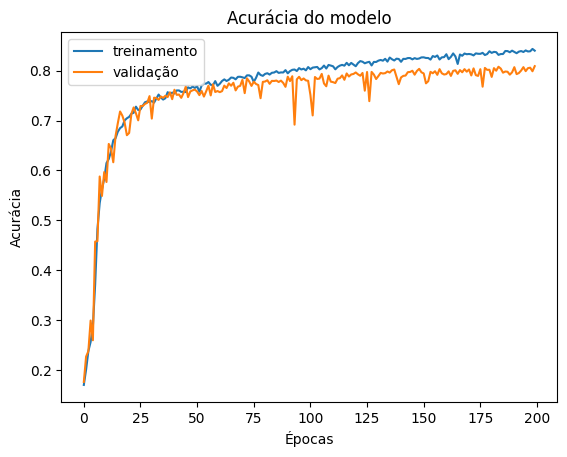

In [14]:
class DataGenerator(Sequence):
    def __init__(self, x_train, y_train, batch_size):
        self.x, self.y = x_train, y_train
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(new_X_train, new_Y_train, 128)
test_gen = DataGenerator(new_X_val, new_Y_val, 128)

# Definição dos valores do lr cíclico
clr = CyclicLR(base_lr=1e-7, max_lr=1e-3, step_size=50)

# Treinamento do modelo
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=(new_X_val, new_Y_val),
    callbacks=[clr, checkpoint],           # Updated with the checkpoint callback
    shuffle=True
)


# Plot da acurácia do treinamento e validação
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['treinamento', 'validação'], loc='upper left')
plt.show()

In [11]:
# Carrega melhor modelo obtido
model = tf.keras.models.load_model('best_model_cnn_3.h5')

2024-12-11 11:58:43.910925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-11 11:58:43.911508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-11 11:58:43.911596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

/tmp/ipykernel_32696/1725456917.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_modulations)
2024-12-11 11:58:44.725282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907


 9/13 [===================>..........] - ETA: 0s 

2024-12-11 11:58:45.771696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


138/138 [==============================] - 1s 7ms/step


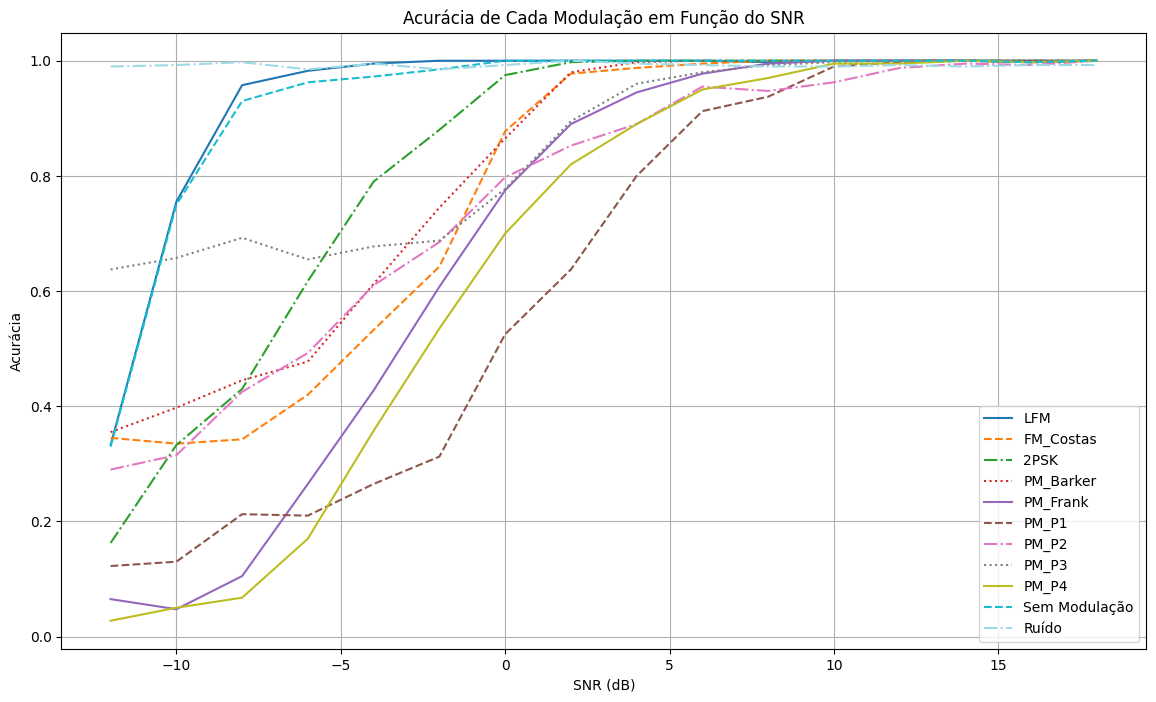

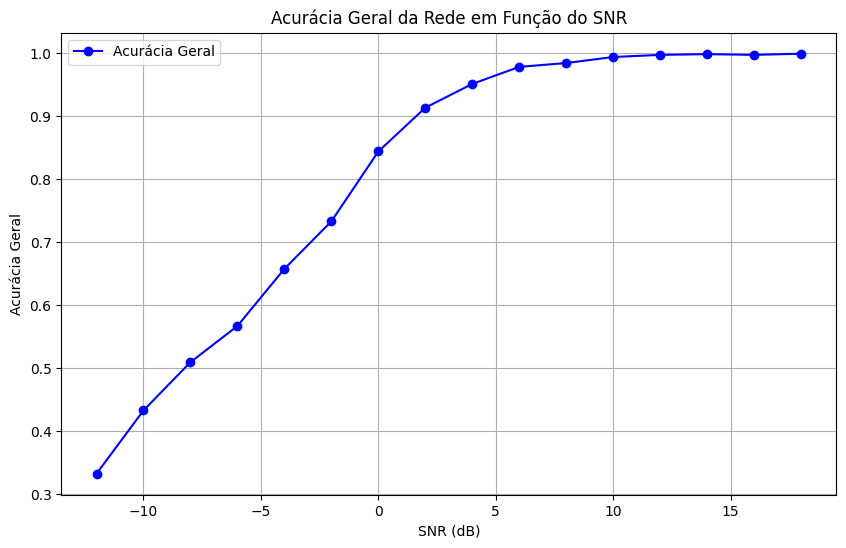

In [12]:
# Extração do SNR e a classe dos sinais
snr_values = np.arange(-12, 20, 2)
num_snr = len(snr_values)
num_modulations = len(desired_vals)

# Lista de nomes das modulações
modulation_names = [
"LFM", "FM_Costas", "2PSK", "PM_Barker", "PM_Frank", "PM_P1", "PM_P2", "PM_P3", "PM_P4", "Sem Modulação", "Ruído"
]

line_styles = ['-', '--', '-.', ':'] * 6
colors = plt.cm.get_cmap('tab20', num_modulations)

# Inicializar matriz para acurácia por modulação e lista para acurácia geral
accuracy_per_modulation = np.zeros((num_modulations, num_snr))
overall_accuracy = []

# Processar cada modulação para calcular a acurácia por faixa de SNR
for mod_idx in range(num_modulations):
    modulation_indices = np.where(new_Y_test[:, mod_idx] == 1)[0]
    x_modulation = new_X_test[modulation_indices]
    y_modulation = new_Y_test[modulation_indices]
    z_modulation = new_lbl_test[modulation_indices, 1]  # SNR está na segunda coluna de lbl_data

    for snr_idx, snr in enumerate(snr_values):
        snr_indices = np.where(z_modulation == snr)[0]
        x_snr = x_modulation[snr_indices]
        y_snr = y_modulation[snr_indices]
        
        if len(x_snr) == 0:
            accuracy_per_modulation[mod_idx, snr_idx] = np.nan
            continue
        
        # Fazer predições com o modelo
        predictions_snr = model.predict(x_snr)
        
        # Calcular a acurácia
        accuracy = np.mean(np.argmax(predictions_snr, axis=1) == np.argmax(y_snr, axis=1))
        accuracy_per_modulation[mod_idx, snr_idx] = accuracy

# Calcular a acurácia geral para cada faixa de SNR
for snr in snr_values:
    snr_indices = np.where(new_lbl_test[:, 1] == snr)[0]  # SNR está na segunda coluna de lbl_data
    x_snr = new_X_test[snr_indices]
    y_snr = new_Y_test[snr_indices]

    if len(x_snr) == 0:
        overall_accuracy.append(np.nan)
        continue

    # Fazer predições com o modelo
    predictions_snr = model.predict(x_snr)

    # Calcular a acurácia geral
    accuracy = np.mean(np.argmax(predictions_snr, axis=1) == np.argmax(y_snr, axis=1))
    overall_accuracy.append(accuracy)

# Converter para array numpy para facilitar o plot
overall_accuracy = np.array(overall_accuracy)

# Plotar a acurácia por modulação
plt.figure(figsize=(14, 8))
for mod_idx in range(num_modulations):
    plt.plot(
        snr_values,
        accuracy_per_modulation[mod_idx],
        label=modulation_names[mod_idx],
        linestyle=line_styles[mod_idx % len(line_styles)],
        color=colors(mod_idx)
    )

plt.xlabel("SNR (dB)")
plt.ylabel("Acurácia")
plt.title("Acurácia de Cada Modulação em Função do SNR")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Plotar a acurácia geral
plt.figure(figsize=(10, 6))
plt.plot(snr_values, overall_accuracy, marker='o', linestyle='-', color='b', label='Acurácia Geral')

plt.xlabel("SNR (dB)")
plt.ylabel("Acurácia Geral")
plt.title("Acurácia Geral da Rede em Função do SNR")
plt.grid(True)
plt.legend()
plt.show()


In [13]:
# Diretório de logs para o profiler
log_dir = "logs/profiler_inference"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Medir o tempo de inferência
start_time = time.time()

# Realiza predições
predictions = model.predict(new_X_test)

# Medir o tempo de inferência
end_time = time.time()
inference_time = end_time - start_time

# Imprimir tempo de inferência
print(f"Tempo de inferência: {inference_time:.4f} segundos")

2338/2338 [==============================] - 15s 7ms/step
Tempo de inferência: 19.0136 segundos



Relatório de Classificação:
               precision    recall  f1-score   support

          LFM       0.99      0.94      0.97      6800
    FM_Costas       0.88      0.79      0.83      6800
         2PSK       0.94      0.83      0.88      6800
    PM_Barker       0.85      0.82      0.83      6800
     PM_Frank       0.84      0.71      0.77      6800
        PM_P1       0.77      0.65      0.71      6800
        PM_P2       0.71      0.78      0.74      6800
        PM_P3       0.58      0.86      0.69      6800
        PM_P4       0.79      0.68      0.73      6800
Sem Modulação       0.91      0.94      0.92      6800
        Ruído       0.88      0.99      0.93      6800

     accuracy                           0.82     74800
    macro avg       0.83      0.82      0.82     74800
 weighted avg       0.83      0.82      0.82     74800



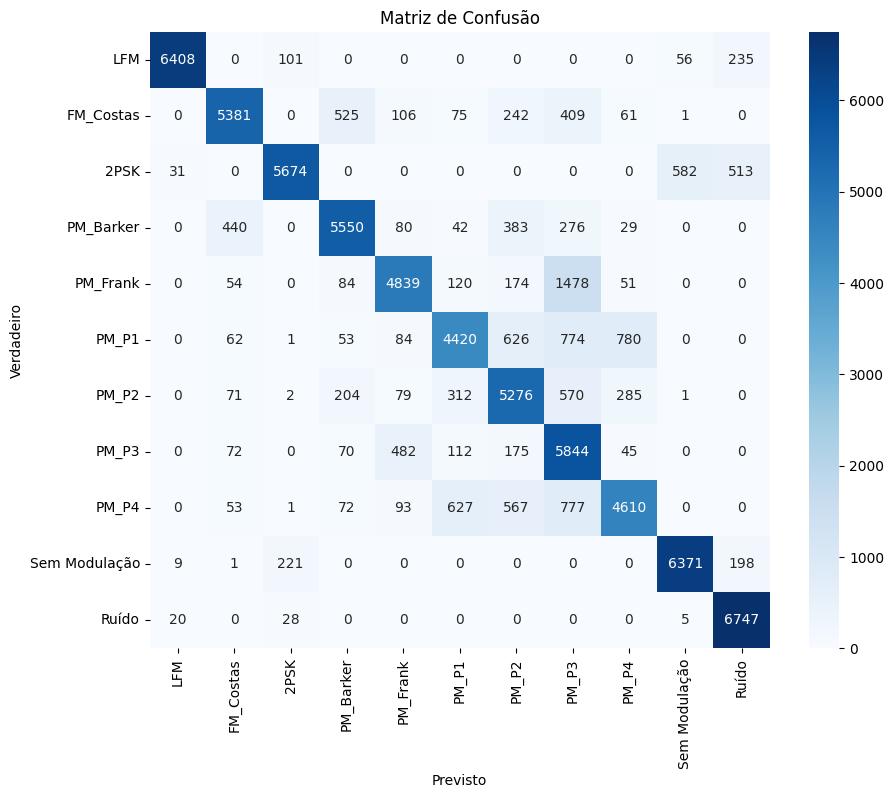

In [14]:
# Predição utilizando melhor modelo obtido
y_pred = np.argmax(predictions, axis=1)

# Conversão do formato one hot para categórico
if len(new_Y_test.shape) > 1 and new_Y_test.shape[1] > 1:
    new_Y_test = np.argmax(new_Y_test, axis=1)

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(new_Y_test, y_pred, target_names=modulation_names))

# Matriz de confusão
conf_matrix = confusion_matrix(new_Y_test, y_pred)

# Visualização da matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=modulation_names, 
            yticklabels=modulation_names)
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()